<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdevnotebooks.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Finetune Llama3 using Direct Preference Optimization (DPO) 🤙

Welcome!

This is part 2 of our Llama3 finetuning series. Our last notebook was focused on using Supervised Finetuning (SFT) to finetune the Llama3-8B base model. In this one, we're going to take a different approach to finetuning and instead use Direct Preference Optimization. In our next notebook, we'll use ORPO - a novel technique that combines SFT and DPO into a single process!

#### Help us make this tutorial better! Please provide feedback on the [Discord channel](https://discord.gg/T9bUNqMS8d) or on [X](https://x.com/brevdev).

A note about running Jupyter Notebooks: Press Shift + Enter to run a cell. A * in the left-hand cell box means the cell is running. A number means it has completed. If your Notebook is acting weird, you can interrupt a too-long process by interrupting the kernel (Kernel tab -> Interrupt Kernel) or even restarting the kernel (Kernel tab -> Restart Kernel). Note restarting the kernel will require you to run everything from the beginning.

Adapted from: [Maxime Labonne](https://twitter.com/maximelabonne)

## Introduction to finetuning using SFT and RLHF

At a high level, finetuning invovles taking a pre-trained LLM (like Llama3, Mistral7b, etc) and controlling its ouput for a certain task. This could be making a model respond in a company-specific manner, generating code in a specific format, or optimizing its performance in an academic field. Most guides online talk about finetuning using Supervised Finetuning (SFT). SFT involves retraining a model on input:output pairs essentially teaching a model what the correct output is given a specific type of input. SFT is extremely useful when you have a large amount of specific labeled data and when the tasks are well defined. Notice how there is no feedback loop in SFT. Once the dataset is created and the finetuning starts, the model does not receive any "feedback" on its performance. It simply learns the output based on the input provided. 

In order to add feedback, we can use a concept called RLHF. RLHF extends the SFT process by having a separate trained "reward" model which approximates human feedback. This reward model provides scores to each LLM completion and serves as a proxy for a human evaluating an LLM response. This reward model optimizes a fine-tuned models output using the Promixal Policy Algorithm (PPO). PPO revolves around making smaller updates to a models policy in order to improve its performance based on preference. Hoever, PPO is still relatively unstable and difficult to reproduce. Along with that, training a separate reward model requires more data and is computationally expensive!

![RLHF](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*GiEF7F3n-1TlL7_HRJD_OA.png)

## How does DPO improve this

Direct Preference Optimization improves on a lot of the shortcomings of RLHF. Essentially, DPO treats a task as a classification problem. It uses 2 models: the trained model and a copy it called the reference model. During DPO traning, the goal is to make sure the trained model outputs higher probabilities for preferred answers and lower probabilities for rejected answers compared to the reference model. Because the LLM uses itself as a reward model, it is able to align itself without need for a reward model or extensive sampling and hyperparamter tuning. This results in a more stable and less computationally intensive process. 

Note that under the hood, finetuning with DPO is still a 2 stage process: SFT then DPO!

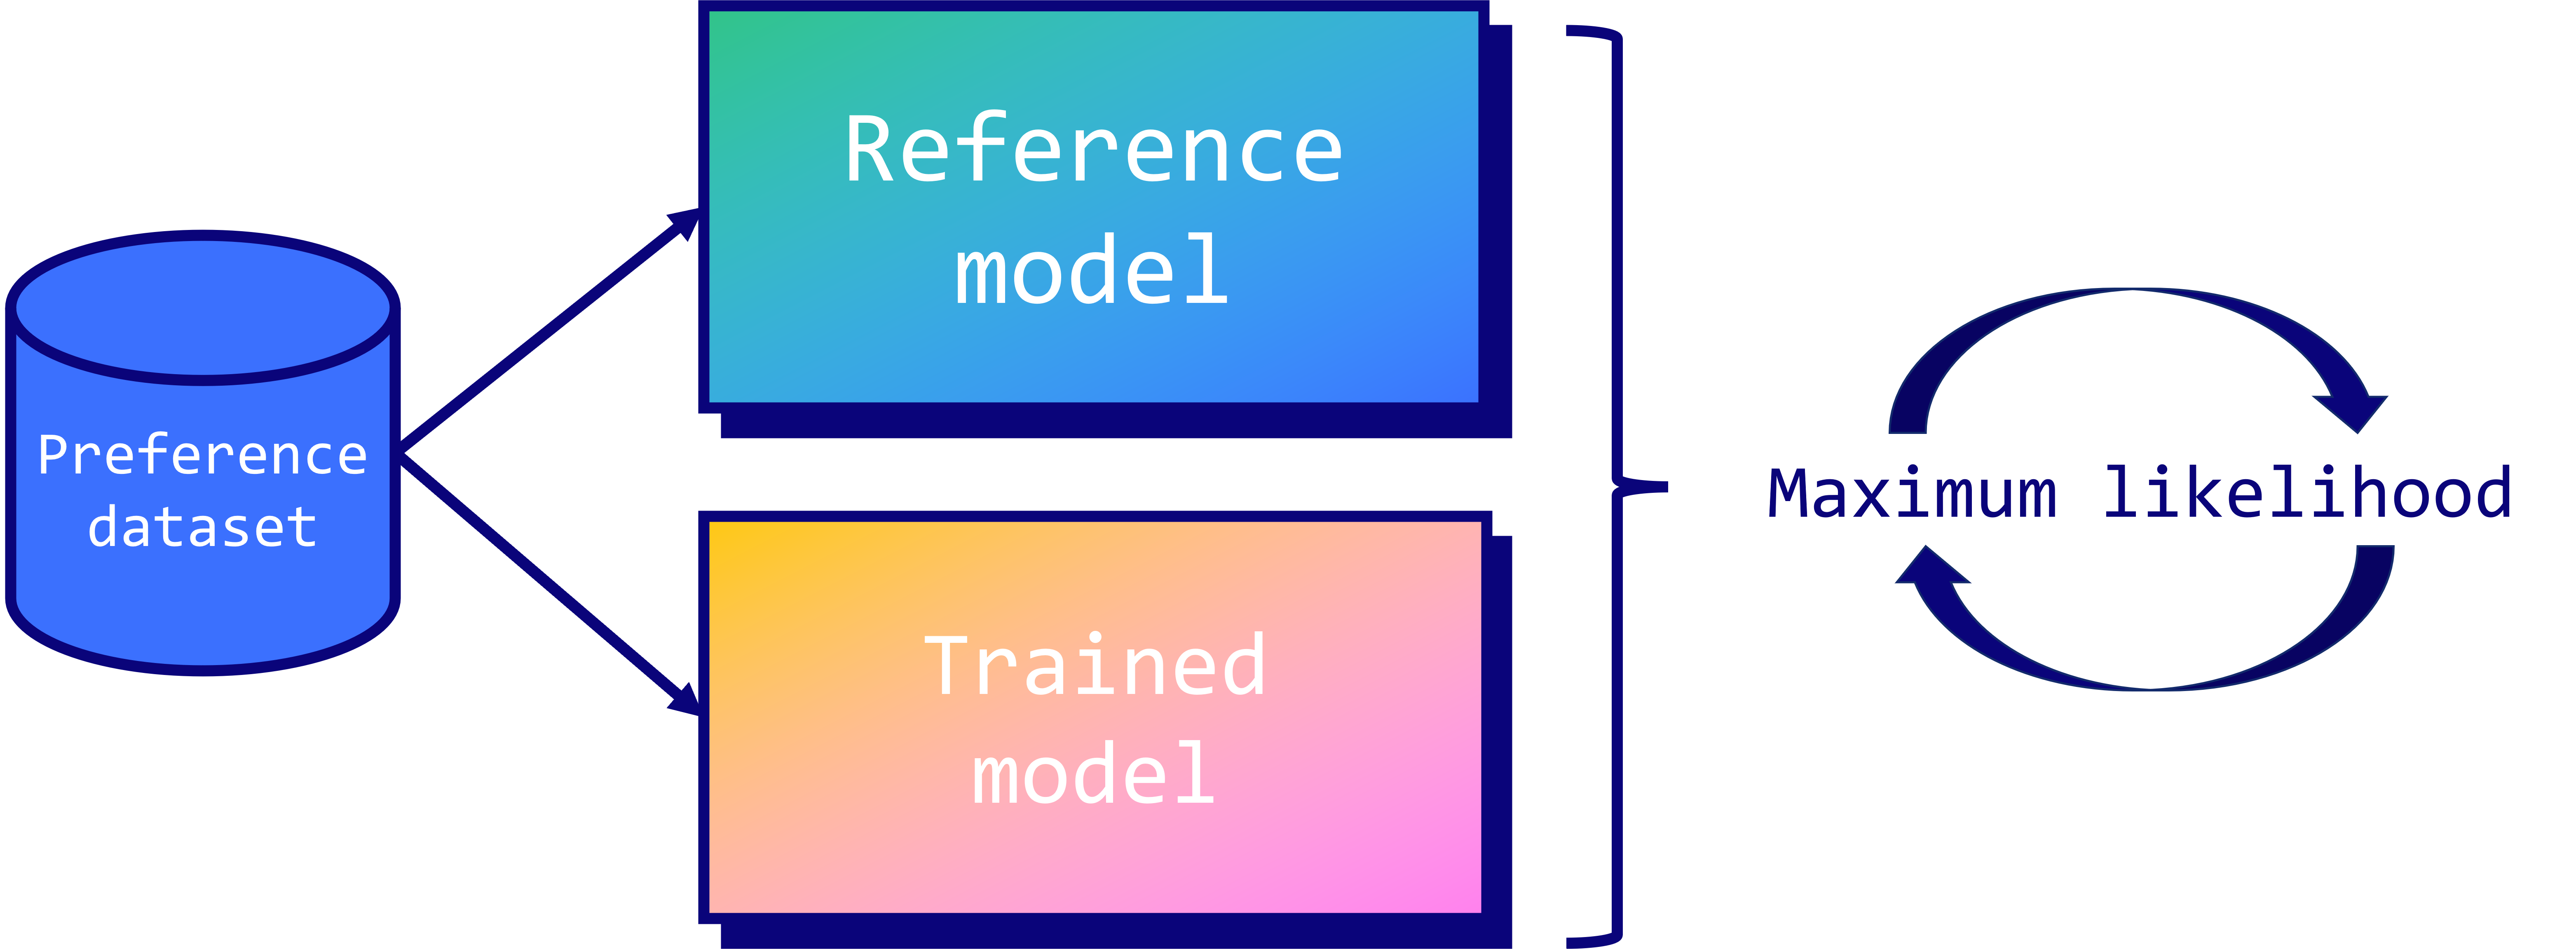

## Install dependencies

In [ ]:
!pip install datasets trl peft bitsandbytes wandb accelerate transformers

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import os
import gc
import torch
import transformers
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    TrainingArguments, 
    BitsAndBytesConfig
)
from datasets import load_dataset
from peft import (
    LoraConfig, 
    PeftModel, 
    get_peft_model, 
    prepare_model_for_kbit_training
)
from trl import DPOTrainer, setup_chat_format
import bitsandbytes as bnb

## Load the model and tokenizer

Note that we also load in a reference model. This is for completeness. If we did not provide one, the DPOTrainer will automatically create one for us

In [ ]:
base_model = "meta-llama/Meta-Llama-3-8B-Instruct"
new_model = "BrevDPOLlama-3-8B"

In [ ]:
# The bits and bytes config we use for quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
)
# Reference model
ref_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
)

In [ ]:
# LoRA configuration
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['k_proj', 'gate_proj', 'v_proj', 'up_proj', 'q_proj', 'o_proj', 'down_proj']
)

## Load and format dataset

Preference datasets are a little unique as I explained above. Let's take a look

In [ ]:
# Load dataset
dataset = load_dataset("Intel/orca_dpo_pairs")['train']

In [ ]:
# In this notebook we use a subset of 150 samples. In order to do a full tune, you can use the entire dataset
# The seed allows for reproducability. If you run this notebook exactly, you will use the same 100 samples as me
dataset = dataset.shuffle(seed=42).select(range(1000))

In [ ]:
dataset

Preference datasets contain the original prompt along with `chosen` and `rejected` columns. These are our preferences. We want the model to respond in a certain way. Uncomment the cells below and tinker around to see why different answers were rejected or chosen!

In [ ]:
dataset[19]['question']

In [ ]:
dataset[19]['rejected']

In [ ]:
dataset[19]['chosen']

Now we format the dataset in order to follow the Llama3 format using the extremely helpful chat templates created by chujiezheng

In [ ]:
!wget -L https://raw.githubusercontent.com/chujiezheng/chat_templates/main/chat_templates/llama-3-chat.jinja

In [ ]:
chat_template = open('llama-3-chat.jinja').read()
chat_template = chat_template.replace('    ', '').replace('\n', '')
tokenizer.chat_template = chat_template

In [ ]:
def dataset_format(example):
    # Format system
    if len(example['system']) > 0:
        message = {"role": "system", "content": example['system']}
        system = tokenizer.apply_chat_template([message], tokenize=False)
    else:
        system = ""
    # Format instruction
    message = {"role": "user", "content": example['question']}
    prompt = tokenizer.apply_chat_template([message], tokenize=False, add_generation_prompt=True)
    # Format chosen answer
    chosen = example['chosen'] + "<|eot_id|>\n"
    # Format rejected answer
    rejected = example['rejected'] + "<|eot_id|>\n"
    return {
        "prompt": system + prompt,
        "chosen": chosen,
        "rejected": rejected,
    }

In [ ]:
original_columns = dataset.column_names
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

dataset = dataset.map(
    dataset_format,
    remove_columns=original_columns,
    num_proc= os.cpu_count(),
)

In [ ]:
# notice the specific llama3 tags like <|eot_id|> which show that the chat template formatting worked
dataset[19]

## Create the DPO trainer

In [ ]:
import wandb

wandb.login()

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    max_steps=200,
    save_strategy="no",
    logging_steps=1,
    output_dir=new_model,
    optim="paged_adamw_32bit",
    warmup_steps=100,
    bf16=True,
    report_to="wandb",
)

In [ ]:
dpo_trainer = DPOTrainer(
    model,
    ref_model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=tokenizer,
    peft_config=peft_config,
    beta=0.1,
    max_prompt_length=512,
    max_length=1024,
    force_use_ref_model=True
)

In [ ]:
!nvidia-smi

In [ ]:
# Fine-tune model with DPO
dpo_trainer.train()

## Analyze training run 

Lets take a deeper look at our training run. Specifically, the `train/rewards/chosen, train/rewards/rejected`. This plot corresponds to the mean difference between the log probabilities output by the trained and reference model. Notice that over time they diverge which shows that the model is learning the preferred answer type. 

Additionally, take a look at the `train/reward/accuracies` graph which shows frequency of choosing preferred answer. This could be a good sign but could also mean that the difference between the chosen and rejected answer in our dataset is too obvious.

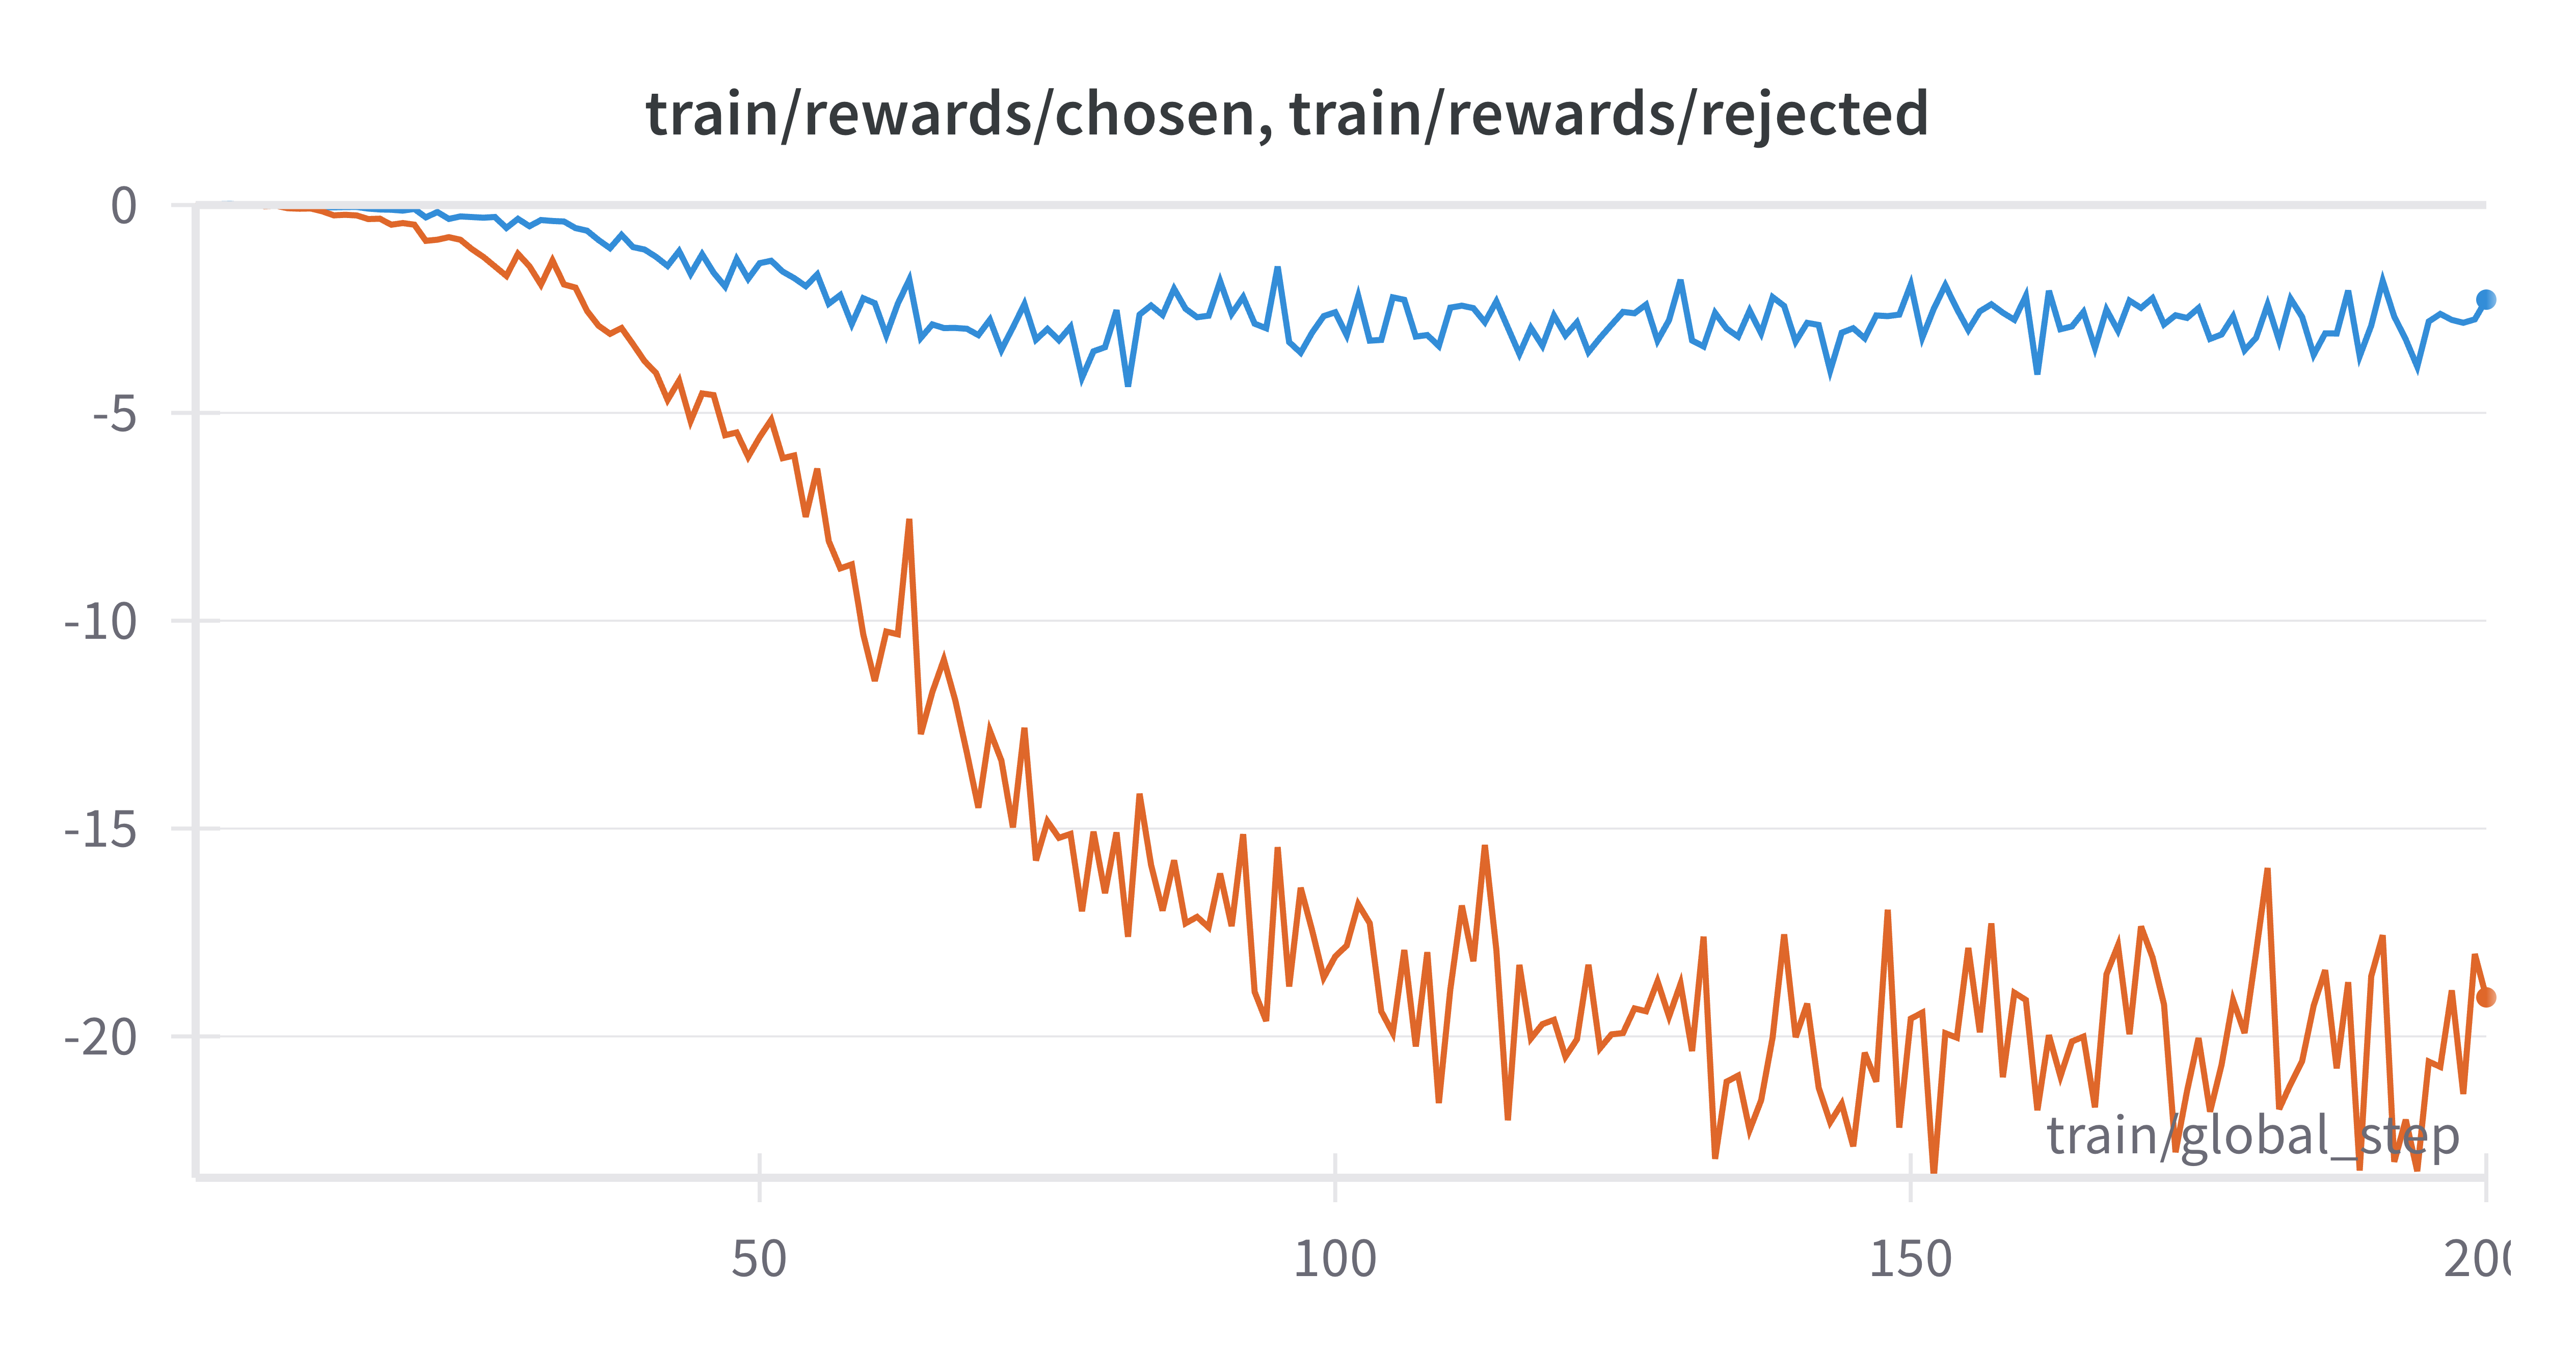

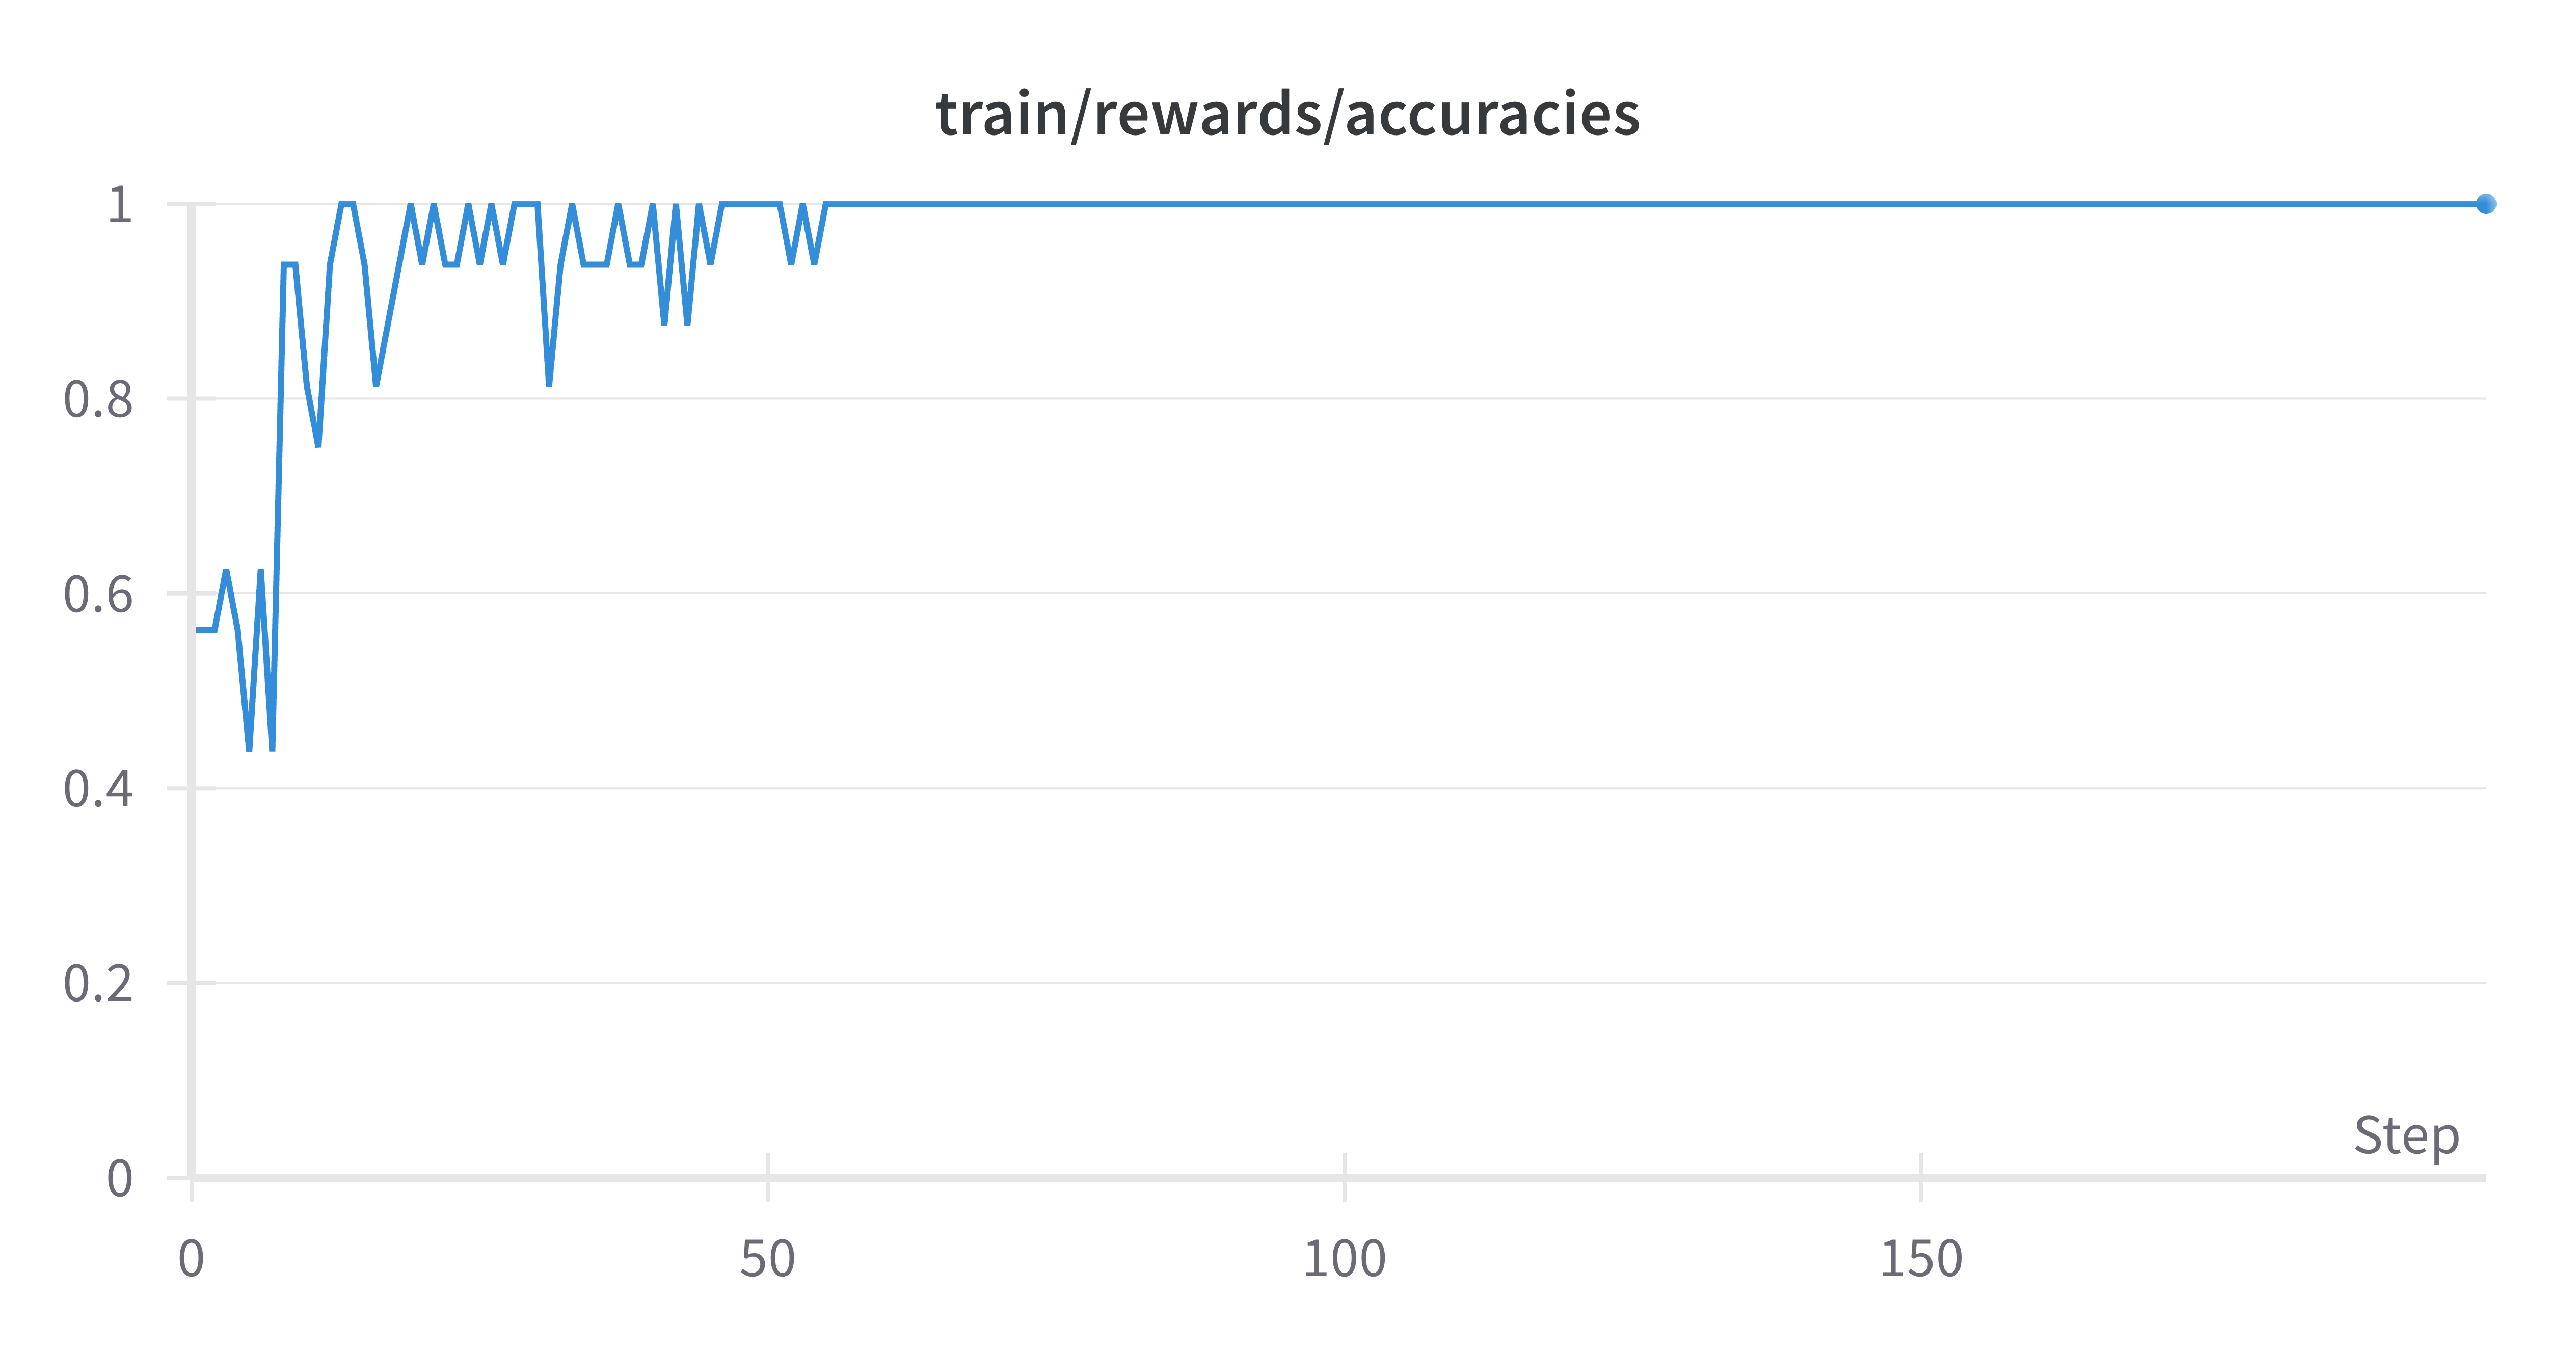

## Save and test model

In [ ]:
dpo_trainer.model.save_pretrained("final_ckpt")

In [ ]:
tokenizer.save_pretrained("final_ckpt")

In [ ]:
# Flush memory
del dpo_trainer, model, ref_model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Reload model in FP16 (instead of NF4)
base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    return_dict=True,
    torch_dtype=torch.float16,
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
tokenizer.chat_template = chat_template

In [ ]:
# Merge base model with the adapter
model = PeftModel.from_pretrained(base_model, "final_ckpt")
model = model.merge_and_unload()

# Save model and tokenizer
model.save_pretrained(new_model)
tokenizer.save_pretrained(new_model)

In [ ]:
# Create pipeline
pipeline = transformers.pipeline(
    "text-generation",
    model=new_model,
    tokenizer=tokenizer
)

In [ ]:
# Format prompt
message = [
    {"role": "system", "content": "You are a helpful assistant chatbot that provides concise answers."},
    {"role": "user", "content": "What are GPUs and why would I use them for machine learning tasks?"}
]
tokenizer = AutoTokenizer.from_pretrained(new_model)
prompt = tokenizer.apply_chat_template(message, add_generation_prompt=True, tokenize=False)

# Generate text
sequences = pipeline(
    prompt,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    num_return_sequences=1,
    max_length=200,
)
print(sequences[0]['generated_text'])